# Demo de Algoritmos de Regresión para generar fórmulas que permite estimar datos


In [ ]:
#@title Librerías a usar
import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

import os
import csv

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import math

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [ ]:
# @title Acceder al Drive {"single-column":true}

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = '/content/gdrive/MyDrive/demosColab/demoIA/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [ ]:
#@title Cargar datos

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}
separador_decimal = '.' #@param {type:"string"}

# funciones auxiliares

# importa datos
def cargarDatosDF(path, archivo_datos, delimitador_columnas, separador_decimal, mostrarEstadisticas=True):
  if os.path.isfile( path + '/' + archivo_datos ):
    # existe el archivo
    if ((delimitador_columnas is None) or (delimitador_columnas=="")):
      # si no se define asume ","
      delimitador_columnas = ","
    if ((separador_decimal is None) or (separador_decimal=="")):
      # si no se define asume "."
      separador_decimal = "."
    if (delimitador_columnas==separador_decimal):
      # ambos delimitadores iguales, cambia el decimal
      if delimitador_columnas == ",":
        separador_decimal = "."
      else:
        separador_decimal = ","
      print("- Ambos delimitadores configurados igual, se cambia separador decimal a '" + separador_decimal + "'!")
    # carga datos
    df = pd.read_csv(path + archivo_datos,
                     sep=delimitador_columnas, decimal=separador_decimal,
                     skip_blank_lines=True,
                     engine="python")
    print("> Archivo de datos", archivo_datos, "cargado")
    # muestra estadísticas
    if mostrarEstadisticas:
      print("\n> Cabecera: ")
      print(df.head())
      print("\n> Características: ")
      print(df.describe())
      print("\n")
    # controla que el archivo tenga sentido
    if len(df.columns.values.tolist())<2:
      print("\n> El archivo de datos debería tener al menos 2 columnas, revise delimitador de columnas!")
      return None
    else:
      return df
  else:
    print("No existe archivo de datos ", archivo_datos, "!")
    return None

# importa definición axiliar de las clases (si existe)
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    # si existe, carga los datos
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    # no encontrado
    return "", ""

# inicializa valores
X = None
Y = None

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## aplicación de los parámetros elegidos

# Carga los datos del CSV y muestra los primeros
df = cargarDatosDF(path, archivo_datos,
                   delimitador_columnas, separador_decimal, mostrarEstadisticas=True)

if df is not None:

  # intenta cargar configuración asociada a los datos
  # trata de obtener la configuración del archivo asociado
  atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

  # muestra interface para cargar configuración de los parámetros

  # función auxiliara para que no ejecute UI cada vez
  def hacerNada():
      return

  # se define esta función para que se ocupe de aplicar la configuración
  def on_buttonAplicar_clicked(b):
      print("")
      funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

  # aplica configuración de datos
  def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
      global Y, X, nombre_clases

      if (attClase is None) or (attClase =="") or\
        (att_entrada is None) or (att_entrada ==""):
        return

      # si el atributo clase está como de entrada, lo saca (no tiene sentido)
      att_entrada = list(att_entrada)
      if (attClase in att_entrada):
        print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
        att_entrada.remove( attClase )

      if (att_entrada == "") or (len(att_entrada)==0):
        print("No se han definido atributos de entrada!")
        return

      # guarda configuración
      nombre_clases = nomClases

      # genera los datos solo con los atributos seleccionados
      # para clase
      if (attClase in df):
        Y = np.array(df[attClase])
      else:
        print("Atributo " + attClase + " no encontrado !")
        X = None
        Y = None
        return
      # para entrada
      X = np.array(df[att_entrada])

      # muestra resultados
      print("\n> Atributos entrada: ", att_entrada)
      print("\t X: ", X.shape)

      if (nombre_clases is None) or (nombre_clases==""):
        print("\n> Atributo clase: ", attClase)
      else:
        print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
      print("\t Y: ", Y.shape)

  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}

  tit = widgets.Label("Ajuste para configuración de los Datos: ")

  # prepara combo para determinar atributo clase
  selecc_atributos = [ ]
  selecc_atributos.extend( df.columns.values.tolist() )
  if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
    att_selecc_defecto = len(selecc_atributos)-1
  else:
    att_selecc_defecto = selecc_atributos.index(atributo_clase)
  combo_att_clase = widgets.Dropdown(
      options = selecc_atributos,
      value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
      description = 'Atributo clase:',
      style=style_3D,
      disabled = False,
  )
  # prepara campo para ingresar nombre clases (toma por defecto de config)
  texto_nomClases = widgets.Text(
      value=nombre_clases,
      placeholder='Ingrese nombre clases (si corresponde) separados por comas',
      description='Nombre clases:',
      style=style_3D,
      disabled=False
  )

  combo_att_entrada = widgets.SelectMultiple(
      options=selecc_atributos,
      value=selecc_atributos,
      #rows=10,
      description='Atributos de entrada:',
      style=style_3D,
      disabled=False
  )

  # prepara botón y grilla con objetos
  btnAplicar = widgets.Button(
      description='Aplicar'
  )
  configDatos_ui = widgets.GridBox(
        children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
        layout=Layout(width='100%')  )
  btnAplicar.on_click(on_buttonAplicar_clicked)

  #clear_output()
  out_config = widgets.interactive_output(hacerNada, {})
  display(configDatos_ui)

  # ejecuta para que muestre
  on_buttonAplicar_clicked(btnAplicar)


> Archivo de datos IRIS.csv cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Clase como de entrada dado que es clase.

> Atributos entrada:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo']
	 X:  (150, 4)

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)


In [ ]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "continuo - ESTIMACION" #@param [ "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100.0

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# inicializa listas
x_train, x_test, y_train, y_test = [], [], [], []
y_trainEnc, y_testEnc = [], []

# control aque haya datos definidos
assert (X is not None), "No se cargaron datos de atributos de entrada!"
assert (len(X)>0), "No se cargaron datos de atributos de entrada!"
assert (Y is not None), "No se cargaron datos de atributo clase!"
assert (len(Y)>0), "No se cargaron datos de atributos de entrada!"

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("** No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)

CLASES = []
if esProblemaClasificacion:
  ## CLASIFICAR
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
    # toma los valores de clase orginales del archivo
    if str(Y[0]).replace(".","").isnumeric():
      # Y son números
      print("-- Utiliza valores numéricos como clase.")
      for val in range(int(np.max(Y))+1):
        CLASES.append( "clase {:>3}".format(val) )
    else:
        # Y no son números
        print("-- Utiliza valores alfanuméricos como clase.")
        CLASES = list(set(Y))
        CLASES.sort()
        # cambia valores para que sean enteros
        y_train = [ CLASES.index(y) for y in y_train]
        y_test = [ CLASES.index(y) for y in y_test]
  else:
    # toma configuración de nombre de clases
    print("-- Utiliza nombres de clase definidos.")
    for val in nombre_clases.split(','):
      CLASES.append( val )

  # controla, con advertencias
  if len(CLASES) == 0:
    print("** No se encontraron clases!\n")
  elif len(CLASES) > 10:
    print("** Se detectaron más de 10 clases, revise los datos y el tipo de problema seleccionado!\n")

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES )
else:
  ## ESTIMAR
  print("> se considera problema de ESTIMACIÓN \n")
  if not(str(Y[0]).replace(".","").isnumeric()):
    print("-- Detecta valores alfanuméricos en atributo clase -> convierte a númerico:")
    CLASES = list(set(Y))
    CLASES.sort()
    # cambia valores para que sean enteros
    y_train = [ CLASES.index(y) for y in y_train]
    y_test = [ CLASES.index(y) for y in y_test]
    print(" - dictMapeo (", len(CLASES), "): ", [ str(i) + " : " +CLASES[i]  for i in range(len(CLASES)) ] )

# convierte a numpy para usar por modelo
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# muestra ejemplos
print("\n> Datos para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    print("    ", CLASES[i], "[", i, "]:", np.sum(y_train == i))

print("\n Datos para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    print("    ", CLASES[i], "[", i, "]:", np.sum(y_test == i))
print("")

# Hace copia de los datos
# porque Polynomial Regression los cambia
import copy
x_train_BAK = copy.deepcopy(x_train)
x_test_BAK = copy.deepcopy(x_test)



> se considera problema de ESTIMACIÓN 


> Datos para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 4)
 - y_train (cant):  112

 Datos para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 4)
 - y_test (cant):  38



# Modelo:

In [ ]:
#@title Aplicar Algoritmo de Regresión

# parámetros
tipo_modelo = "Polynomial Regression"  #@param [ "Linear Regression", "Logistic Regression", "Polynomial Regression"  ]
max_degree_polynomial_features = 0 #@param {type:"integer"}

if max_degree_polynomial_features < 1:
  max_degree_polynomial_features = 1
elif max_degree_polynomial_features > 5:
  max_degree_polynomial_features = 5


# Recupera copia de los datos
# porque Polynomial Regression los cambia
x_train = copy.deepcopy(x_train_BAK)
x_test = copy.deepcopy(x_test_BAK)

# funciones para mostrar fórmula
def genFormulaLinear(model, atributos):
  s = "   y = " + str(model.intercept_)
  for i in range(len(model.coef_)):
    c = model.coef_[i]
    if c < 0:
      s = s + "\n\t    - "
    else:
      s = s + "\n\t    + "
    s = s + str(abs(c)) + " * "
    if atributos is None:
        s = s + "x"+str(i+1)
    else:
        s = s + atributos[i]
  return s


def genFormulaRegresion(model, atributos):
  s = "    y = argMax {"
  for v in range(len(model.intercept_)):
    claseInter= model.intercept_[v]
    claseCoefs = model.coef_[v]
    s = s + "\n\t\tP(y="+str(v+1)+") = 1 / [ 1 + exp( "
    s = s + "\n\t\t\t\t\t" + str(claseInter)
    for i in range(len(claseCoefs)):
      c = claseCoefs[i]
      s = s + "\n\t\t\t\t\t"
      if c < 0:
        s = s + "- "
      else:
        s = s + "+ "
      s = s + str(abs(c)) + " * "
      if atributos is None:
        s = s + "x"+str(i+1)
      else:
        s = s + atributos[i]
    s = s + " ) ];"
  if len(s)>1:
    s = s[:len(s)-1] + "\n               } "
  return s

def genFormulaPolynomical(model, poly, atributos):
  # formatea nombre parámetros
  coefNames = poly.get_feature_names_out()
  for j in range(len(coefNames)):
    coefNames[j] = coefNames[j].replace(" ", " * ")
    if atributos is not None:
      for i in range(len(atributos)):
        coefNames[j] = coefNames[j].replace("x"+str(i), atributos[i])
  s = "   y = " + str(model.intercept_)
  for i in range(len(model.coef_)):
    c = model.coef_[i]
    if c < 0:
      s = s + "\n\t    - "
    else:
      s = s + "\n\t    + "
    s = s + str(abs(c)) + " * " + coefNames[i]
  return s

def mostrarFormula(tipo_modelo, model, poly, atributos):
  print("> Fórmula:")
  formula = "??"
  if tipo_modelo == "Linear Regression":
    formula = genFormulaLinear(model, combo_att_entrada.value)
  elif tipo_modelo == "Logistic Regression":
    formula =  genFormulaRegresion(model, combo_att_entrada.value)
  elif tipo_modelo == "Polynomial Regression":
    formula =  genFormulaPolynomical(model, poly, combo_att_entrada.value)
  else:
    print("Tipo de modelo desconocido: ", tipo_modelo)
  print(formula)


# Determina modelo a usar
poly = None
if tipo_modelo == "Linear Regression":
  model = linear_model.LinearRegression()
  y = y_train
elif tipo_modelo == "Logistic Regression":
  model = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)
  y = np.round(y_train).astype(int)
elif tipo_modelo == "Polynomial Regression":
  #specify degree of N for polynomial regression model
  #include bias=False means don't force y-intercept to equal zero
  poly = PolynomialFeatures(degree=max_degree_polynomial_features,
                            interaction_only=False,
                            include_bias=False)
  # transforma datos de entrenamiento y prueba
  # para que sean polinomial
  x_train = poly.fit_transform(x_train)
  x_test = poly.transform(x_test)
  y = y_train
  # define modelo como lineal
  model = linear_model.LinearRegression(fit_intercept=True)
else:
  print("Modelo no definido!!!")
  model = None

# entrena modelo
model.fit(x_train, y)

# muestra fórmula
mostrarFormula(tipo_modelo, model, poly, combo_att_entrada.value)

##print(model.coef_, "\n", model.intercept_)


> Fórmula:
   y = 1.0152005928602807
	    - 0.027895201043103276 * LargoSepalo
	    - 0.09047293518408855 * AnchoSepalo
	    + 0.17282826266826468 * LargoPetalo
	    + 0.6363772358123321 * AnchoPetalo


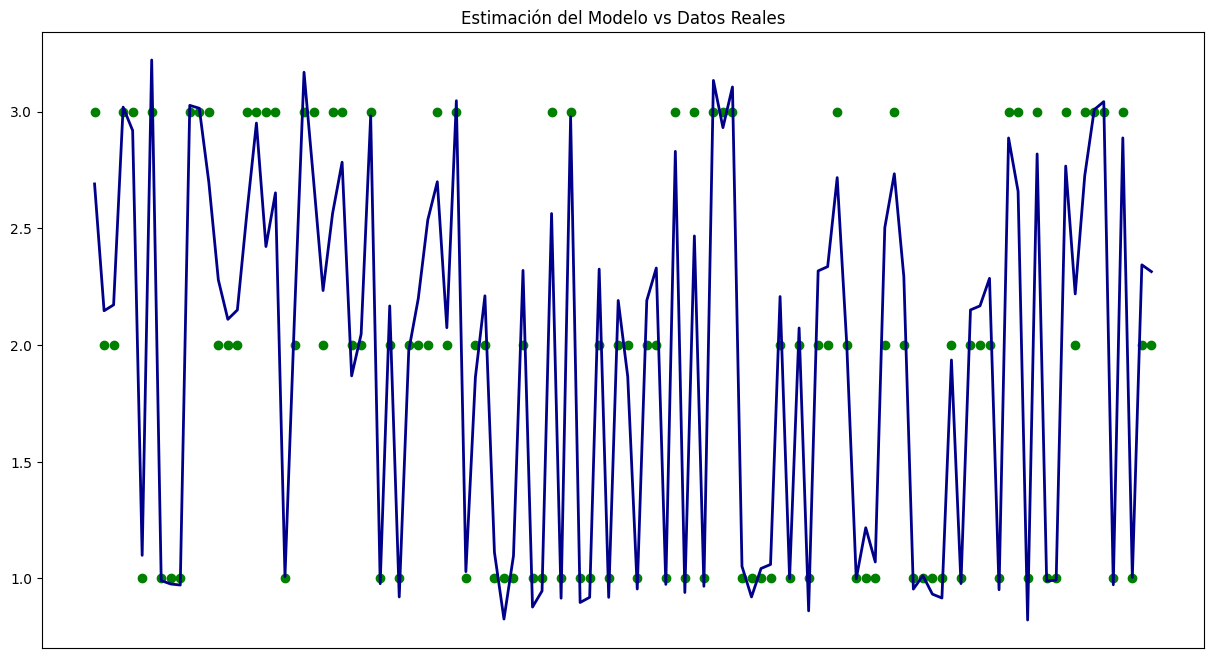

In [ ]:
#@title Mostrar Gráfico de Regresión

usar_datos = "Entrenamiento" #@param ["Entrenamiento", "Prueba"]

if usar_datos == "Entrenamiento":
  x = x_train
  y = y_train
else:
  x = x_test
  y = y_test

xEls = range(len(y)) ## x[:,0]

# muestra el árbol
plt.figure(figsize=(15,8))

yModel = model.predict(x)

# Plot outputs
plt.scatter(xEls, y, color="green")
plt.plot(xEls, yModel, color="darkblue", linewidth=2)
plt.title("Estimación del Modelo vs Datos Reales")
plt.xticks(())
#plt.yticks(())

plt.show()


### Evaluación del Modelo:

*** Resultados con datos de Entrenamiento: 

 Estadísticas para Error Absoluto: 
            Mínimo: 0.0007 
            Promedio: 0.1540 ± 0.1344
            Máximo: 0.5779 


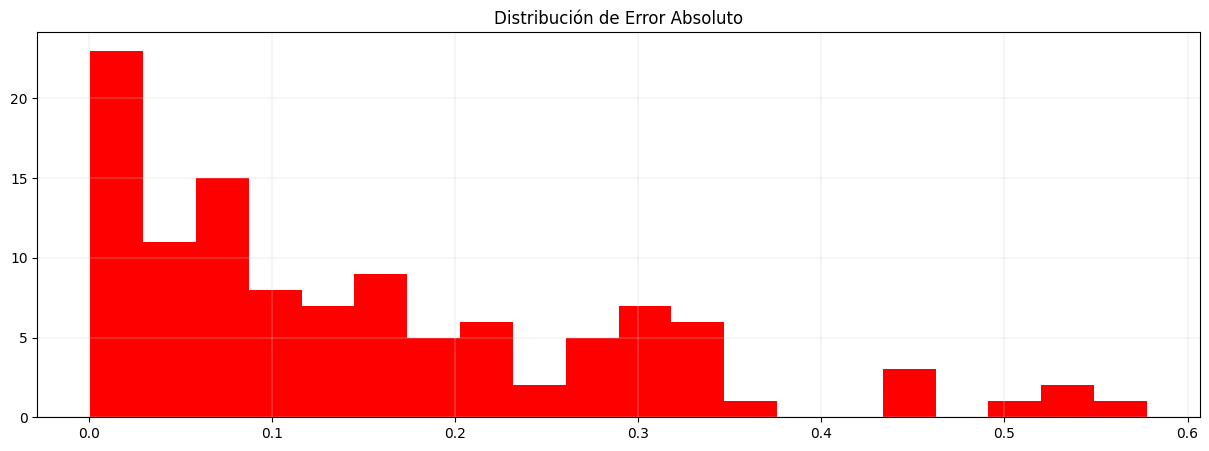


 Estadísticas para Error Relativo: 
            Mínimo: 0.0675 
            Promedio: 7.7640 ± 5.7334
            Máximo: 26.8080 


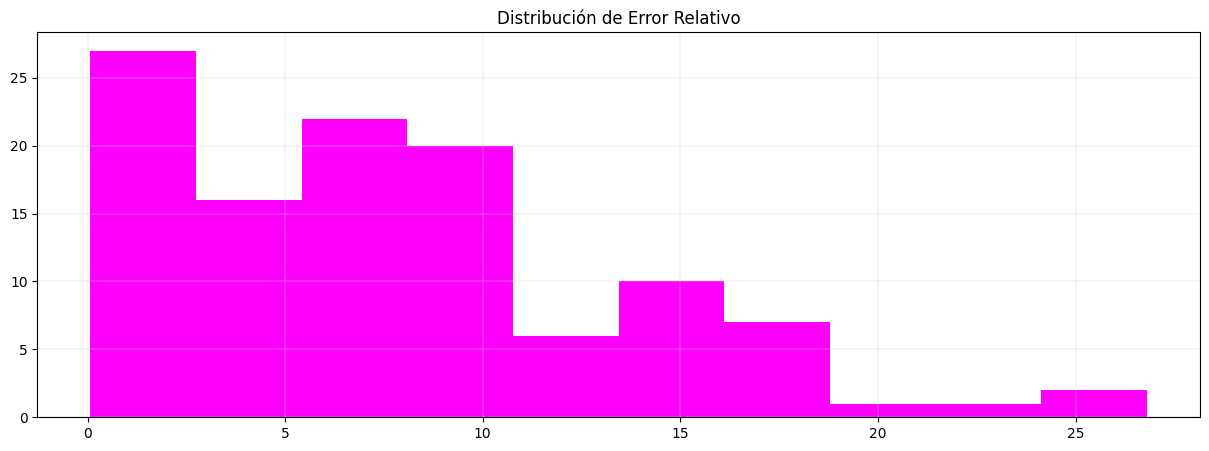

In [ ]:
#@title Evaluar con datos de entrenamiento

umbral_clasificacion = 50 #param {type:"slider", min:1, max:99, step:1}
#markdown ('umbral_clasificacion' sólo se usa para clasificación con salida lineal)
mostrar_detalle_entrenamiento = False #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}

# genera gráfico de los errores para Estimación
def generaResumen_Estimacion(ar, tit, b=10, c=None):
    # muestra resumen
    print("\n Estadísticas para " + tit + ": ")
    print("            Mínimo: {:.4f} ".format(np.min(ar)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(ar), np.std(ar)) )
    print("            Máximo: {:.4f} ".format(np.max(ar)) )
    # muestra gráfico
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()
    return

# función auxiliar para probar el modelo entrenado para Estimación
def analizarModelo_Estimacion(datosX, datosY, predsY, mostrarDetalle=False, inclDatosEntrada=False):
    # muestra títulos
    if mostrarDetalle:
      if inclDatosEntrada:
        print(" Datos ->", end="")
      print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")
    # procesa
    arAbs = []
    arRel = []
    for x, r, pV in zip(datosX, datosY, predsY):
      # toma el valor estimado/predecido
      p = interpretarPredsModelo(pV, esProblemaClasificacion=False)
      # controla que sean números
      if not(math.isnan(r) or math.isnan(p)):
        # hace los cálculos
        eAbs = abs(r - p)
        if r == 0:
          eRel = (eAbs / 1)*100.0
        else:
          eRel = (eAbs / r)*100.0
        # agrega a lista para estadística
        arAbs.append(eAbs)
        arRel.append(eRel)
        # muestra
        if mostrarDetalle:
          if inclDatosEntrada:
            print(" " + str(x) + "->", end="")
          print(" R: {:>10.4f} / M: {:>10.4f} [ {:>10.4f} | {:>10.2f}% ]".format(r, p, eAbs, eRel))
      else:
        # muestra inválidis
        if mostrarDetalle:
          if inclDatosEntrada:
            print(" " + str(x) + "->", end="")
          print(" descarta valores inválidos R: ", r," / M: ", p, "!")
    # muestra estadísticas de métricas
    generaResumen_Estimacion(arAbs, "Error Absoluto", 20, "red")
    generaResumen_Estimacion(arRel, "Error Relativo", 10, "magenta")
    return

# función que interpreta resultados modelo
# de acuerdo a tipo de problem y configuración de clases
def interpretarPredsModelo(predY, esProblemaClasificacion, tipo_output_softMax=False, umbralClas=0.5):
  # ESTIMACIÓN: devuelve primer valor
  return predY

# método general para evaluar modelo
def evaluarModelo(modelo, esProblemaClasificacion, datosX, datosY, clases_map=None, tipo_output_softMax=False, umbralClas=0.5, mostrarDetalle=False, inclDatosEntrada=False):
    # procesa los datos de entrada con el modelo
    predsY = modelo.predict(datosX)
    # muestra resultados
    analizarModelo_Estimacion(datosX, datosY, predsY,
                                mostrarDetalle=mostrarDetalle, inclDatosEntrada=inclDatosEntrada)

    return

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
evaluarModelo(model, esProblemaClasificacion=False,
              datosX=x_train, datosY=y_train,
              mostrarDetalle=mostrar_detalle_entrenamiento,
              inclDatosEntrada=incluirDatosEntrada_detalle_entrenamiento)




*** Resultados con datos de Prueba: 
 Datos -> Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]
 [6.2 2.2 4.5 1.5]-> R:     2.0000 / M:     2.3755 [     0.3755 |      18.78% ]
 [4.9 2.5 4.5 1.7]-> R:     3.0000 / M:     2.5119 [     0.4881 |      16.27% ]
 [5.  2.3 3.3 1. ]-> R:     2.0000 / M:     1.8743 [     0.1257 |       6.28% ]
 [5.1 3.8 1.5 0.3]-> R:     1.0000 / M:     0.9793 [     0.0207 |       2.07% ]
 [6.3 3.3 4.7 1.6]-> R:     2.0000 / M:     2.3714 [     0.3714 |      18.57% ]
 [5.  3.3 1.4 0.2]-> R:     1.0000 / M:     0.9464 [     0.0536 |       5.36% ]
 [6.4 3.2 5.3 2.3]-> R:     3.0000 / M:     2.9268 [     0.0732 |       2.44% ]
 [6.  3.  4.8 1.8]-> R:     3.0000 / M:     2.5515 [     0.4485 |      14.95% ]
 [5.2 3.4 1.4 0.2]-> R:     1.0000 / M:     0.9318 [     0.0682 |       6.82% ]
 [5.1 3.5 1.4 0.2]-> R:     1.0000 / M:     0.9255 [     0.0745 |       7.45% ]
 [5.8 2.7 4.1 1. ]-> R:     2.0000 / M:     1.9541 [     0.0459 |       2.29% ]
 [6.3 2.7

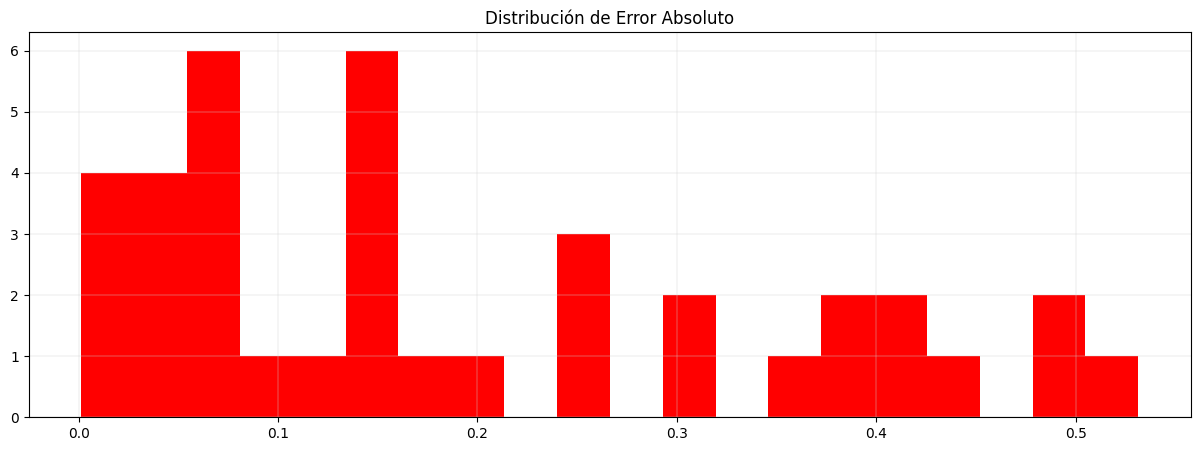


 Estadísticas para Error Relativo: 
            Mínimo: 0.0702 
            Promedio: 9.0959 ± 6.4075
            Máximo: 25.1433 


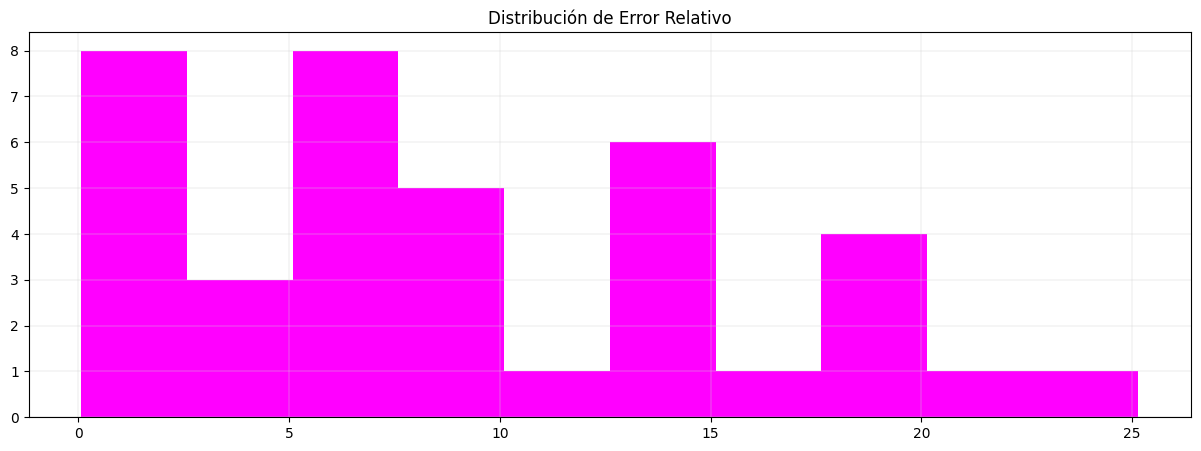

In [ ]:
#@title Evaluar con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = True #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
# muestra resultados
evaluarModelo(model, esProblemaClasificacion=False,
              datosX=x_test, datosY=y_test,
              mostrarDetalle=mostrar_detalle_prueba,
              inclDatosEntrada=incluirDatosEntrada_detalle_prueba)
